In [12]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import scienceplots
%matplotlib inline
from seaborn import displot, histplot, scatterplot, relplot
plt.style.use(['seaborn-v0_8-paper'])
from tqdm import tqdm
from shapely.geometry import LineString
from conflict import ConflictLyft

with open('./lyft_avhv_conflict.pkl', 'rb') as file:
    lyft_avhv_conflict_list = pickle.load(file)

with open('./lyft_hvhv_conflict.pkl', 'rb') as file:
    lyft_hvhv_conflict_list = pickle.load(file)

lyft_conflict_list = lyft_avhv_conflict_list + lyft_hvhv_conflict_list

# convert the type to latest conflict object
conflict_list = list()
for c_index, c in enumerate(lyft_conflict_list):
    # print(c_index)
    conflict_list.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
    ))
assert len(conflict_list) == len(lyft_conflict_list)

C:\Users\LocalAdmin\Documents\GitHub\lyft_intersection\extract_intersections\conflict.py:172: RuntimeWarning: divide by zero encountered in scalar divide
  follower_trajectory_length / self.follower_beforeConflict_speeds[follower_index] - \
C:\Users\LocalAdmin\Documents\GitHub\lyft_intersection\extract_intersections\conflict.py:173: RuntimeWarning: divide by zero encountered in scalar divide
  leader_trajectory_length / self.leader_beforeConflict_speeds[leader_index]
C:\Users\LocalAdmin\Documents\GitHub\lyft_intersection\extract_intersections\conflict.py:157: RuntimeWarning: divide by zero encountered in scalar divide
  TTCs.append(follower_trajectory_length / (self.follower_beforeConflict_speeds[follower_index]))


In [13]:
conflict_cols_in_df = [
    # "tfrecord_index", 
    # "scenario_index",
    "conflict_type",
    "Vehicle order",
    "leader_type",
    "follower_type",
    "PET",
    "minTTC",
    "leader_minTTC_speed",
    "follower_minTTC_speed"
]

conflict_rows_in_df = list()
for index, conflict in enumerate(conflict_list):

    minTTC_speeds = conflict.minTTC_speeds
    if len(minTTC_speeds) == 0:
        # pass the special cases
        continue
    else:
        # normal cases with min TTC and speeds (3 elements in the list)
        # print(index)
        minTTC = minTTC_speeds[0]
        leader_minTTC_speed = minTTC_speeds[1]
        follower_minTTC_speed = minTTC_speeds[2]
        
        leader_type = "AV" if conflict.leader_is_av else "HV"
        follower_type = "AV" if conflict.follower_is_av else "HV" 
        conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
        conflict_rows_in_df.append([
            conflict_type,
            leader_type+"-"+follower_type,
            leader_type,
            follower_type,
            conflict.PET,
            minTTC,
            leader_minTTC_speed,
            follower_minTTC_speed,
        ])

conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

"""
Post-process
- Only consider PET <= 10s
"""
PET_THRESHOLD = 10
minTTC_THRESHOLD = 10

conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]
conflict_df = conflict_df[conflict_df["minTTC"] <= minTTC_THRESHOLD]

conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 0 to 708
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   conflict_type          527 non-null    object 
 1   Vehicle order          527 non-null    object 
 2   leader_type            527 non-null    object 
 3   follower_type          527 non-null    object 
 4   PET                    527 non-null    float64
 5   minTTC                 527 non-null    float64
 6   leader_minTTC_speed    527 non-null    float64
 7   follower_minTTC_speed  527 non-null    float64
dtypes: float64(4), object(4)
memory usage: 37.1+ KB


In [14]:
# Post-process: remove TTC greater than 10s
TTC_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["minTTC"] <= minTTC_THRESHOLD]

# display info
conflict_df.info()
conflict_df.to_csv("./outputs/lyft_heatmap_speeds_minTTC.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 0 to 708
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   conflict_type          527 non-null    object 
 1   Vehicle order          527 non-null    object 
 2   leader_type            527 non-null    object 
 3   follower_type          527 non-null    object 
 4   PET                    527 non-null    float64
 5   minTTC                 527 non-null    float64
 6   leader_minTTC_speed    527 non-null    float64
 7   follower_minTTC_speed  527 non-null    float64
dtypes: float64(4), object(4)
memory usage: 37.1+ KB


Text(0.5, 1.0, '(Lyft)')

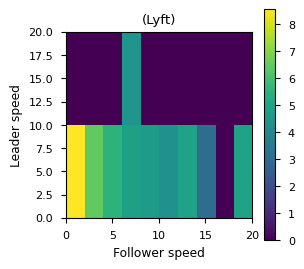

In [27]:
# discretize v1 和 v2
x_nbins = 2
x_bins = np.linspace(0, 20, x_nbins + 1)
y_nbins = 10
y_bins = np.linspace(0, 20, y_nbins + 1)

plt.figure(figsize=(3,3))
df = conflict_df

df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=x_bins, labels=np.arange(x_nbins), include_lowest=True)
df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=y_bins, labels=np.arange(y_nbins), include_lowest=True)

# 计算每个网格中 height 的平均值
grid_avg = df.groupby(['leader_minTTC_speed_bins', 'follower_minTTC_speed_bins'])['minTTC'].mean().unstack()
grid_avg = np.nan_to_num(grid_avg, 0)
plt.imshow(grid_avg, interpolation=None, extent=[0, 20, 0, 20], origin='lower', interpolation_stage="data")
# plt.colorbar()
plt.xlabel("Follower speed")
plt.ylabel("Leader speed")
plt.colorbar()
plt.title("(Lyft)")

In [28]:
grid_avg = df.groupby(['leader_minTTC_speed_bins', 'follower_minTTC_speed_bins'])['minTTC'].mean().unstack()
grid_avg

follower_minTTC_speed_bins,0,1,2,3,4,5,6,7,8,9
leader_minTTC_speed_bins,,,,,,,,,,
0,8.549918,6.476865,5.534019,4.869206,4.698079,4.312962,4.947659,3.092549,NaN,4.970461
1,NaN,NaN,NaN,4.471266,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_21016\3014811718.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_21016\3014811718.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)


Text(0.5, 1.0, 'HV-HV (Lyft)')

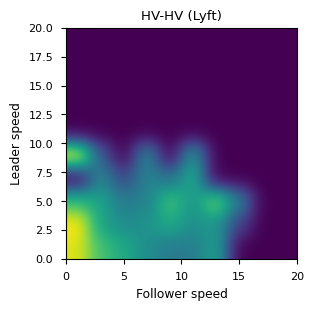

In [5]:
# discretize v1 和 v2
nbins = 10
bins = np.linspace(0, 20, nbins + 1)

plt.figure(figsize=(3,3))

order = "HV-HV"
df = conflict_df[conflict_df["Vehicle order"] == order]

df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)

# 计算每个网格中 height 的平均值
grid_avg = df.groupby(['leader_minTTC_speed_bins', 'follower_minTTC_speed_bins'])['minTTC'].mean().unstack()
grid_avg = np.nan_to_num(grid_avg, 0)
plt.imshow(grid_avg, interpolation="gaussian", extent=[0, 20, 0, 20], origin='lower', interpolation_stage="data")
# plt.colorbar()
plt.xlabel("Follower speed")
plt.ylabel("Leader speed")
plt.title(order + " (Lyft)")

C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_21016\2620208983.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_21016\2620208983.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)


Text(0.5, 1.0, 'HV-AV (Lyft)')

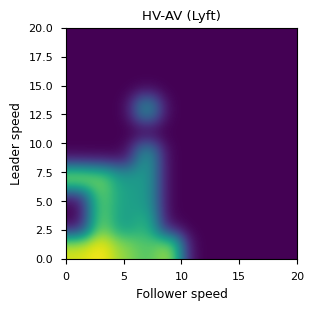

In [10]:
# discretize v1 和 v2
nbins = 10
bins = np.linspace(0, 20, nbins + 1)

plt.figure(figsize=(3,3))

order = "HV-AV"
df = conflict_df[conflict_df["Vehicle order"] == order]

df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)

# 计算每个网格中 height 的平均值
grid_avg = df.groupby(['leader_minTTC_speed_bins', 'follower_minTTC_speed_bins'])['minTTC'].mean().unstack()
grid_avg= np.nan_to_num(grid_avg, 0)
plt.imshow(grid_avg, interpolation="gaussian", extent=[0, 20, 0, 20], origin='lower', interpolation_stage="data")
# plt.colorbar()
plt.xlabel("Follower speed")
plt.ylabel("Leader speed")
plt.title(order + " (Lyft)")

C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_21016\4142374068.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_21016\4142374068.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)


Text(0.5, 1.0, 'AV-HV (Lyft)')

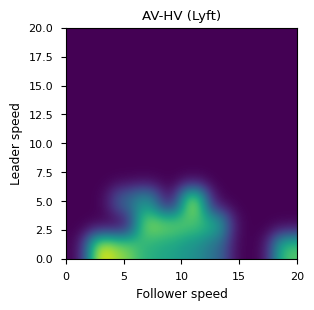

In [9]:
# discretize v1 和 v2
nbins = 10
bins = np.linspace(0, 20, nbins + 1)

plt.figure(figsize=(3,3))

order = "AV-HV"
df = conflict_df[conflict_df["Vehicle order"] == order]

df['leader_minTTC_speed_bins'] = pd.cut(df['leader_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)
df['follower_minTTC_speed_bins'] = pd.cut(df['follower_minTTC_speed'], bins=bins, labels=np.arange(nbins), include_lowest=True)

# 计算每个网格中 height 的平均值
grid_avg = df.groupby(['leader_minTTC_speed_bins', 'follower_minTTC_speed_bins'])['minTTC'].mean().unstack()
grid_avg = np.nan_to_num(grid_avg, 0)
plt.imshow(grid_avg, interpolation="gaussian", extent=[0, 20, 0, 20], origin='lower', interpolation_stage="data")
# plt.colorbar()
plt.xlabel("Follower speed")
plt.ylabel("Leader speed")
plt.title(order + " (Lyft)")